# Imports and Extra Data Cleaning

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
from datetime import timedelta
%load_ext line_profiler
sns.set(style="darkgrid")
import requests
import pprint
import re
%matplotlib inline
pd.set_option('display.max_columns', None)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [19]:
time1 = datetime.now()
filename = 'cleaned_LAX.csv'
# filename = '../big_data/cleaned_flight_data_updated.csv'
# random.seed(234)
# p = 0.03  # p% of lines
df = pd.read_csv(
         filename,
         header=0, 
         parse_dates = ['FL_DATE','dep_datetime','arr_datetime']
#          skiprows=lambda i: i>0 and random.random() > p
)

time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\2pawn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (48,76,77,84,102,104,105,106,108,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:05:43.978776


In [39]:
# # only keep LAX flights
# df = df.loc[df['origin_WBAN'] == 23174]
# # if DEP_DELAY is NaN, drop because useless for our model
# df = df.dropna(subset=['DEP_DELAY'])

df.shape
# df.head()

(423403, 135)

# Binary Classification

Using "DEP_DEL15":
- 1 means delay >= 15
- 0 means delay < 15 (on-time / early)

Goal is to predict this classification. We will use **F1-score** as the primary evaluation metric, since we are concerned with both classes of classificacation: on-time/early vs. delayed. Since the classes are unbalanced, metrics such as accuracy will give a baseline model where we classify all flights as on-time very well (which is misleading since that would not be a useful model). 

Matthews correlation coefficient (**MCC**) is also very useful for our imbalanced class problem, since we care about both precision and recall.

Let's start with a **random forest** weather model, where we predict the DEP_DEL15 using the features:
- weather code - origin
- visibilty - origin
- wind speed at origin
- precipitation at origin
- (possibly temperature)

After weather, we will use flight/airport data:
- number of seats
- departure airport (*need encoding/merging - use passenger count*)
- carrier (*need ordinal encoding*)
- departure time (DEP_TIME)
- duration of flight

Later on if we have time:
- cloud cover (need complicated regex)
- time dependence/delay
- other things

http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

http://scikit-learn.org/stable/modules/model_evaluation.html

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [47]:
# import all these lol
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import zero_one_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing

# Preprocessing

In [67]:
# sort by date for RNN since data was combined from all airports, not chronologically
df = df.sort_values(by=['FL_DATE', 'CRS_DEP_TIME'])
# feature selection for weather model:
# weather code (origin) - encoded ordinally after transform
# visibilty (origin)
# wind speed (origin)
# precipitation (origin)
# don't need origin passenger count now bc it's always the same (LAX)
column_list = ['number_of_seats', 'dest_passenger_count', 'OP_CARRIER_AIRLINE_ID',
                 'DISTANCE', 'DEP_TIME', 'temp_origin_imp', 'precip_origin_imp', 'mfr_name', 'DEP_DEL15']

# change categorical to encoded
categorical_columns = ['mfr_name']
data = pd.get_dummies(df[column_list], columns=categorical_columns)

# standardize
scaler = preprocessing.MinMaxScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

C:\Users\2pawn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [69]:
df.head(10)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,dep_time,dep_datetime,arr_time,arr_datetime,origin_WBAN,dest_WBAN,origin_weather_index,dest_weather_index,mfr_name,model,model_2,mfr_year,cert_year,eng_mfr_name,eng_model,number_of_seats,HOURLYSKYCONDITIONS_origin,HOURLYVISIBILITY_origin,HOURLYPRSENTWEATHERTYPE_origin,HOURLYDRYBULBTEMPF_origin,HOURLYRelativeHumidity_origin,HOURLYWindSpeed_origin,HOURLYWindDirection_origin,HOURLYWindGustSpeed_origin,HOURLYPrecip_origin,HOURLYAltimeterSetting_origin,HOURLYSKYCONDITIONS_dest,HOURLYVISIBILITY_dest,HOURLYPRSENTWEATHERTYPE_dest,HOURLYDRYBULBTEMPF_dest,HOURLYRelativeHumidity_dest,HOURLYWindSpeed_dest,HOURLYWindDirection_dest,HOURLYWindGustSpeed_dest,HOURLYPrecip_dest,HOURLYAltimeterSetting_dest,origin_passenger_count,dest_passenger_count,HOURLYVISIBILITY_origin_imp,HOURLYVISIBILITY_dest_imp,HOURLYWindSpeed_origin_imp,HOURLYWindSpeed_dest_imp,temp_origin_imp,temp_dest_imp,precip_origin_imp,precip_dest_imp,origin_sev_code,dest_sev_code,origin_enc_code,dest_enc_code
10685817,2016,1,1,1,5,2016-01-01,AA,19805,AA,N860AA,2406,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,10,20.0,10.0,10.0,0.0,0.0,0001-0559,26.0,46.0,507.0,4.0,501,511.0,10.0,10.0,0.0,0.0,0001-0559,0.0,NaN,0.0,171.0,171.0,141.0,1.0,1235.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:10:00,2016-01-01 00:10:00,5:01:00,2016-01-01 05:01:00,23174,3927,5657482,4198593,AIRBUS,A321-231,A321,2014.0,2014.0,IAE,V2533-A5,181.0,CLR:00,10.0,NaN,52.0,27.0,NaN,VRB,NaN,0.0,30.08,SCT:04 21 BKN:07 85 BKN:07 130,10.0,NaN,40.0,68,16.0,010,NaN,0.0,30.48,41232432.0,31816933.0,10.0,10.000000,8.11725,16.000000,52.000000,40.00000,0.0,0.000000,0,0,0,0
10773718,2016,1,1,1,5,2016-01-01,AA,19805,AA,N154UW,2078,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,14100,1410002,34100,PHL,"Philadelphia, PA",PA,42,Pennsylvania,23,30,27.0,-3.0,0.0,0.0,-1.0,0001-0559,28.0,55.0,818.0,8.0,837,826.0,-11.0,0.0,0.0,-1.0,0800-0859,0.0,NaN,0.0,307.0,299.0,263.0,1.0,2402.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:30:00,2016-01-01 00:30:00,8:37:00,2016-01-01 08:37:00,23174,13739,5657482,3473341,AIRBUS,A321-211,A321,2013.0,2015.0,CFM INTL,CFM56-5B,187.0,CLR:00,10.0,NaN,52.0,27,NaN,VRB,NaN,0.0,30.08,FEW:02 37 BKN:07 170 OVC:08 260,10.0,NaN,40.0,55,NaN,280,NaN,0.0,30.12,41232432.0,14271243.0,10.0,10.000000,8.11725,8.728851,52.000000,40.00000,0.0,0.000000,0,0,0,0
6962597,2016,1,1,1,5,2016-01-01,AA,19805,AA,N864AA,260,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,13303,1330303,32467,MIA,"Miami, FL",FL,12,Florida,33,30,25.0,-5.0,0.0,0.0,-1.0,0001-0559,28.0,53.0,804.0,6.0,823,810.0,-13.0,0.0,0.

In [70]:
data.head(10)

,number_of_seats,origin_passenger_count,dest_passenger_count,OP_CARRIER_AIRLINE_ID,DISTANCE,DEP_TIME,temp_origin_imp,precip_origin_imp,DEP_DEL15,mfr_name_AIRBUS,mfr_name_BOEING,mfr_name_BOMBARDIER INC,mfr_name_EMBRAER,mfr_name_MCDONNELL DOUGLAS
10685817,0.401840,0.0,0.632948,0.231721,0.453682,0.007920,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10773718,0.420245,0.0,0.283604,0.231721,0.915677,0.010838,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6962597,0.401840,0.0,0.411787,0.231721,0.891924,0.010004,0.401926,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10773724,0.564417,0.0,0.366003,0.223285,0.572447,0.010838,0.177419,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10773723,0.239264,0.0,0.136893,0.231721,0.676168,0.019175,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10773695,0.398773,0.0,0.767864,0.586614,0.655186,0.021676,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3584002,0.420245,0.0,0.437711,0.231721,0.806017,0.021676,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10773696,0.374233,0.0,0.767864,0.231721,0.655186,0.021259,0.177419,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10773720,0.401840,0.0,0.632948,0.231721,0.453682,0.022093,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10773721,0.500000,0.0,0.389776,0.328459,0.510689,0.022509,0.177419,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
data.iloc[:,[8]].head(10)

,DEP_DEL15
25,0.0
26,0.0
32,1.0
120,0.0
134,0.0
142,0.0
147,0.0
162,0.0
214,1.0
274,0.0


In [71]:
look_back = 5 # Number of flights to look back for RNN

def create_dataset(dataset, look_back):
    # Converts dataset to sequences
    dataX = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
    return np.array(dataX)

a = create_dataset(data.values, look_back)

X_train, X_test, y_train, y_test = train_test_split(np.delete(a, [8], axis=2), a[:,:,8], test_size=0.2, random_state=123)

In [72]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (338717, 5, 13)
X_test.shape:  (84680, 5, 13)
y_train.shape:  (338717, 5)
y_test.shape:  (84680, 5)


# RNN

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(5, X_train.shape[-1])))
model.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.2))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 5, 32)             4416      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 23,365
Trainable params: 23,365
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Train on 338717 samples, validate on 84680 samples
Epoch 1/20
338717/338717 [==============================] - 57s 167us/step - loss: 0.5121 - acc: 0.7836 - val_loss: 0.4114 - val_acc: 0.8394
Epoch 2/20
338717/338717 [==============================] - 54s 159us/step - loss: 0.4261 - acc: 0.8268 - val_loss: 0.3847 - val_acc: 0.8454
Epoch 3/20
338717/338717 [==============================] - 54s 159us/step - loss: 0.4114 - acc: 0.8287 - val_loss: 0.3763 - val_acc: 0.8415
Epoch 4/20
338717/338717 [==============================] - 59s 173us/step - loss: 0.4046 - acc: 0.8289 - val_loss: 0.3716 - val_acc: 0.8461
Epoch 5/20
338717/338717 [==============================] - 55s 161us/step - loss: 0.4001 - acc: 0.8296 - val_loss: 0.3707 - val_acc: 0.8451
Epoch 6/20
338717/338717 [==============================] - 54s 158us/step - loss: 0.3970 - acc: 0.8295 - val_loss: 0.3704 - val_acc: 0.8442
Epoch 7/20
338717/338717 [==============================] - 60s 176us/step - loss: 0.3947 - acc: 0.8296

## Results

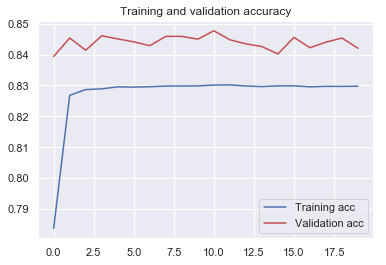

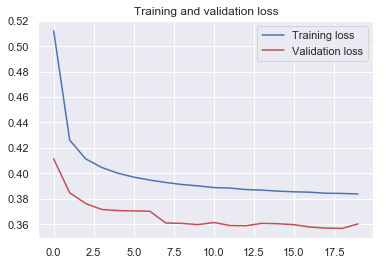

In [77]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Saving Model

In [78]:
# model.save_weights("RNN.h5")
import tensorflow as tf
tf.keras.models.save_model(model,"./LAX_RNN.h5", overwrite=True, include_optimizer=True)

## Assessing Performance

In [83]:
1 - data['DEP_DEL15'].mean()

0.7680673023100922

So, the baseline model would just to be assign 0 to all flights. This gives an accuracy of 76.8%, meaning our validation accuracy of 84.5% is a significant improvement.

In [100]:
data.loc[:, data.columns != 'DEP_DEL15'].head()

,number_of_seats,origin_passenger_count,dest_passenger_count,OP_CARRIER_AIRLINE_ID,DISTANCE,DEP_TIME,temp_origin_imp,precip_origin_imp,mfr_name_AIRBUS,mfr_name_BOEING,mfr_name_BOMBARDIER INC,mfr_name_EMBRAER,mfr_name_MCDONNELL DOUGLAS
10685817,0.401840,0.0,0.632948,0.231721,0.453682,0.007920,0.177419,0.0,1.0,0.0,0.0,0.0,0.0
10773718,0.420245,0.0,0.283604,0.231721,0.915677,0.010838,0.177419,0.0,1.0,0.0,0.0,0.0,0.0
6962597,0.401840,0.0,0.411787,0.231721,0.891924,0.010004,0.401926,0.0,1.0,0.0,0.0,0.0,0.0
10773724,0.564417,0.0,0.366003,0.223285,0.572447,0.010838,0.177419,0.0,0.0,1.0,0.0,0.0,0.0
10773723,0.239264,0.0,0.136893,0.231721,0.676168,0.019175,0.177419,0.0,1.0,0.0,0.0,0.0,0.0


### Random Forest

In [86]:
%%timeit -n 1 -r 1
clf = RandomForestClassifier(n_estimators=23, max_depth=None, 
                             random_state=123)
XRF_train, XRF_test, yRF_train, yRF_test = train_test_split(data.loc[:, data.columns != 'DEP_DEL15'], 
                                                            data['DEP_DEL15'], 
                                                            test_size=0.2, random_state=123)
clf.fit(XRF_train, yRF_train)
print("feature importances: ", clf.feature_importances_)
yRF_pred = clf.predict(XRF_test)
print(classification_report(yRF_test, yRF_pred))
print(confusion_matrix(yRF_test, yRF_pred))
print("accuracy score: ", accuracy_score(yRF_test, yRF_pred))
print("matthews corr coef: ", matthews_corrcoef(yRF_test, yRF_pred))
print("zero one loss: ", zero_one_loss(yRF_test, yRF_pred))
print("balanced accuracy: ", balanced_accuracy_score(yRF_test, yRF_pred))
print("roc auc score: ", roc_auc_score(yRF_test, yRF_pred))

feature importances:  [3.47314070e-02 0.00000000e+00 4.51173648e-02 2.18346863e-02
 4.94939381e-02 6.74462344e-01 1.48525745e-01 2.05701439e-02
 1.32523099e-03 2.26457607e-03 9.00507014e-04 7.70207601e-04
 3.84914336e-06]
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     64863
         1.0       0.74      0.62      0.68     19818

   micro avg       0.86      0.86      0.86     84681
   macro avg       0.82      0.78      0.80     84681
weighted avg       0.86      0.86      0.86     84681

[[60613  4250]
 [ 7441 12377]]
accuracy score:  0.8619406950791795
matthews corr coef:  0.5958194057084598
zero one loss:  0.13805930492082052
balanced accuracy:  0.7795052677435987
roc auc score:  0.7795052677435987
9.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
